# Preparing the Data

In [1]:
import glob

train_filenames = glob.glob('train/*.txt')
val_filenames = glob.glob('val/*.txt')
print(train_filenames)
print(val_filenames)

['train/in.txt', 'train/pk.txt', 'train/fr.txt', 'train/af.txt', 'train/cn.txt', 'train/za.txt', 'train/fi.txt', 'train/ir.txt', 'train/de.txt']
['val/in.txt', 'val/pk.txt', 'val/fr.txt', 'val/af.txt', 'val/cn.txt', 'val/za.txt', 'val/fi.txt', 'val/ir.txt', 'val/de.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
import codecs 
# Build the category_lines dictionary, a list of names per language
category_lines_train = {}
categories_train = []

category_lines_val = {}
categories_val = []


# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename,"r",encoding="utf-8",errors='ignore').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in train_filenames:
    category = filename.split('/')[-1].split('.')[0]
    categories_train.append(category)
    lines = readLines(filename)
    category_lines_train[category] = lines


for filename in val_filenames:
    category = filename.split('/')[-1].split('.')[0]
    categories_val.append(category)
    lines = readLines(filename)
    category_lines_val[category] = lines

    
n_categories = len(categories_train)    
print('n_categories =', n_categories)

n_val_categories = len(categories_val)
print('n_val_categories =', n_val_categories)

n_categories = 9
n_val_categories = 9


In [4]:
categories_train[8]

'de'

In [5]:
print(category_lines_train['de'][:5])

['rudenweiler', 'comunidad pallina grande', 'joao lopes de cima', 'los aymanes de san miguel', 'am badeche']


# Turning Names into Tensors

In [6]:
import torch

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [7]:
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [8]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


# Creating the Network¶

In [9]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

# Manually testing the network

In [10]:
n_hidden = 90
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
input = Variable(line_to_tensor('rudenweiler'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.2117, -2.2057, -2.1954, -2.1725, -2.1528, -2.2273, -2.1528, -2.2603,
         -2.2014]], grad_fn=<LogSoftmaxBackward>)


/Users/ziranmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Preparing for Training

In [12]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return categories_train[category_i], category_i

print(category_from_output(output))

('cn', tensor(4))


In [13]:
import random

def random_training_pair(all_categories, category_lines):                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair(categories_train, category_lines_train)
    print('category =', category, '/ line =', line)

category = za / line = nuzayzah
category = za / line = zamezhnitsa
category = za / line = kamenischkaskakawiza
category = af / line = qalehye mollaye lang
category = in / line = tunkra
category = ir / line = noshveh
category = za / line = manzan
category = ir / line = kavajag
category = in / line = clason point
category = cn / line = dongguakeng


In [14]:
for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair(categories_val, category_lines_val)
    print('category =', category, '/ line =', line)

category = in / line = lapkino
category = cn / line = xiakoucun
category = af / line = lougramaf
category = za / line = zaohejiang
category = za / line = gutshwe
category = fr / line = kafr barshum al kubra
category = ir / line = kiraai
category = fi / line = le gleffien
category = de / line = ardeu
category = cn / line = yenkochuang


# Training the Network

In [15]:
criterion = nn.NLLLoss()

In [16]:
learning_rate = 0.0015 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [17]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [18]:
def getloss(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
    return loss.item()

In [19]:
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

In [20]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

current_loss_v = 0
all_losses_v = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair(categories_train, category_lines_train)
    category_v, line_v, category_tensor_v, line_tensor_v = random_training_pair(categories_val, category_lines_val)
    
    output, loss = train(category_tensor, line_tensor)
    #loss_v = getloss(category_tensor_v, line_tensor_v)
    output_v = evaluate(line_tensor_v)
    loss_v = criterion(output_v, category_tensor_v)
    
    current_loss += loss
    current_loss_v += loss_v
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
        all_losses_v.append(current_loss_v / plot_every)
        current_loss_v = 0

/Users/ziranmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 13s) 2.1326 saindak / af ✗ (pk)
10000 10% (0m 27s) 2.0890 bhaguwala / fi ✗ (pk)
15000 15% (0m 41s) 1.8627 huangbaokeng / cn ✓
20000 20% (0m 55s) 2.2742 shirramore / fr ✗ (ir)
25000 25% (1m 11s) 1.9092 zarach / af ✗ (za)
30000 30% (1m 26s) 0.8167 concellette / fr ✓
35000 35% (1m 41s) 1.2045 garden village park / de ✓
40000 40% (1m 56s) 2.1711 reifing / in ✗ (fi)
45000 45% (2m 11s) 1.3541 gunah / af ✓
50000 50% (2m 26s) 1.0826 izotkino / in ✓
55000 55% (2m 41s) 1.7715 san juan de torres / fr ✗ (de)
60000 60% (2m 56s) 2.1943 marwura / fi ✗ (af)
65000 65% (3m 11s) 1.2917 bunleix / fr ✓
70000 70% (3m 26s) 1.1994 birrlufig / fi ✓
75000 75% (3m 40s) 0.5509 xihuping / cn ✓
80000 80% (3m 56s) 0.5027 kaka rezaye olya / za ✓
85000 85% (4m 11s) 1.2964 ar rufi / fi ✓
90000 90% (4m 26s) 1.7990 baghisaghirha / pk ✗ (af)
95000 95% (4m 39s) 0.6323 thieudeme / de ✓
100000 100% (4m 54s) 1.8637 besh baghan / pk ✗ (ir)


# Plotting the Results

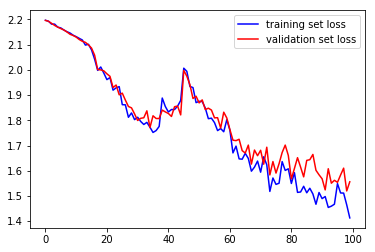

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses, label= "training set loss", color = 'blue')
plt.plot(all_losses_v, label= "validation set loss", color = 'red')
plt.legend()

# Evaluating the Results

In [26]:
n_categories

9

/Users/ziranmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


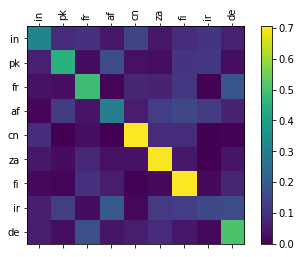

Macro Accuracy: 0.480810
Micro Accuracy: 0.481600


In [23]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair(categories_val, category_lines_val)
    
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = categories_val.index(category)
    
    confusion[category_i][guess_i] += 1
    micro_confusion = confusion.clone()
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + categories_val, rotation=90)
ax.set_yticklabels([''] + categories_val)

# Force label at every tick
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()




cnt = 0
for i in range(confusion.shape[0]):
    cnt+= confusion[i][i]
macro_accuracy = cnt/confusion.shape[0]
print("Macro Accuracy: %f"%macro_accuracy)

cnt = 0
for i in range(micro_confusion.shape[0]):
    cnt+= micro_confusion[i][i]
micro_accuracy = cnt/n_confusion
print("Micro Accuracy: %f"%micro_accuracy)

